<a href="https://colab.research.google.com/github/compi1234/spchlab/blob/master/session3/timit-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classification of Speech Frames

### PART III:  RECOGNIZE a VOWEL FROM CEPSTRAL or FILTERBANK FEATURES

### 1. Setting up your Python Environment
 
1. Import Python's Machine Learning Stack

2. Import needed local utilities that are needed for this exercise

In [1]:
# Importing Python's baseline machine learning stack 
#
% matplotlib inline
import sys,os,io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as sio
import urllib.request

# imports from the scikit-learn 
from sklearn.datasets.base import Bunch
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Perceptron
from sklearn import metrics as skmetrics
from sklearn.mixture import GaussianMixture
from scipy.fftpack import dct

try:
  import google.colab
  IN_COLAB = True
  ! pip install git+https://github.com/compi1234/spchlab.git
except:
  IN_COLAB = False

from spchutils.hildata import fetch_hillenbrand



In [104]:
# choose the colors you like :)
palette = sns.color_palette("bright")
# palette=['red','green','blue','orange','brown','black','dodgerblue','mediumturquoise','cyan','violet','gold','salmon'] 
# sns.palplot(palette)
sns.set_palette(palette)

### 2. The Database 
The experiments in this notebook use a subset of the TIMIT database.
There is FILTERBANK data from 3 vowels (i,a,uw) , 400 samples for training and 200 samples for testing.
The data is 24-dimensional (24 channels in the filterbank).
http://homes.esat.kuleuven.be/~spchlab/datasets/tinytimit/README.txt

In the cell below the data is loaded into
- data matrices   FBANK_train(2400,3), FBANK_test(600,3)
- labels          y_train(2400,), y_test(600,)

In [3]:
# loads all data in a matlab file at given url to the contents structure
# this is working for MATLAB 7.0 files and older ; not hdf5 MATLAB 7.3 or more recent
def load_matlab_from_url(url):
    url_response = urllib.request.urlopen(url)
    matio = io.BytesIO(url_response.read())
    contents = sio.loadmat(matio,squeeze_me=True)
    return(contents)
#
# we will import 400 train samples and 200 test samples for 3 vowels
tinytimit = 'http://homes.esat.kuleuven.be/~spchlab/datasets/tinytimit/'
url_mf = tinytimit + 'male-female.mat' 
data_mf = load_matlab_from_url(url_mf)
url_vow3= tinytimit + 'a-i-uw-800.mat' 
data_vow3 = load_matlab_from_url(url_vow3)
FB_train=data_vow3['ALLtrain'].T
FB_test=data_vow3['ALLtest'].T
y_train =np.full((2400,),'a',dtype='<U2')
y_train[800:1600] =np.full((800,),'i',dtype='<U2')
y_train[1600:2400] =np.full((800,),'uw',dtype='<U2')
y_test =np.full((600,),'a',dtype='<U2')
y_test[200:400] =np.full((200,),'i',dtype='<U2')
y_test[400:600] =np.full((200,),'uw',dtype='<U2')
classes = np.unique(y_train)

### 3a. Data Exploration ... of filterbank data

How to explore data in 24-dimensional space ?

There is no trivial answer to this question.  
First we try to visualize scatter plots of the first couple of filterbank energies

Scatter plots may give us an insight as to which features are most relevant.
We can make a simple scatter plot with 2 preselected features, or can have a conglomerate of scatter plots for a getter overview

##### Tasks & Questions (1)
1. What do the scatter plots tell you.  Are there features that must be retained or others that can surely be dropped ?

<Figure size 720x720 with 0 Axes>

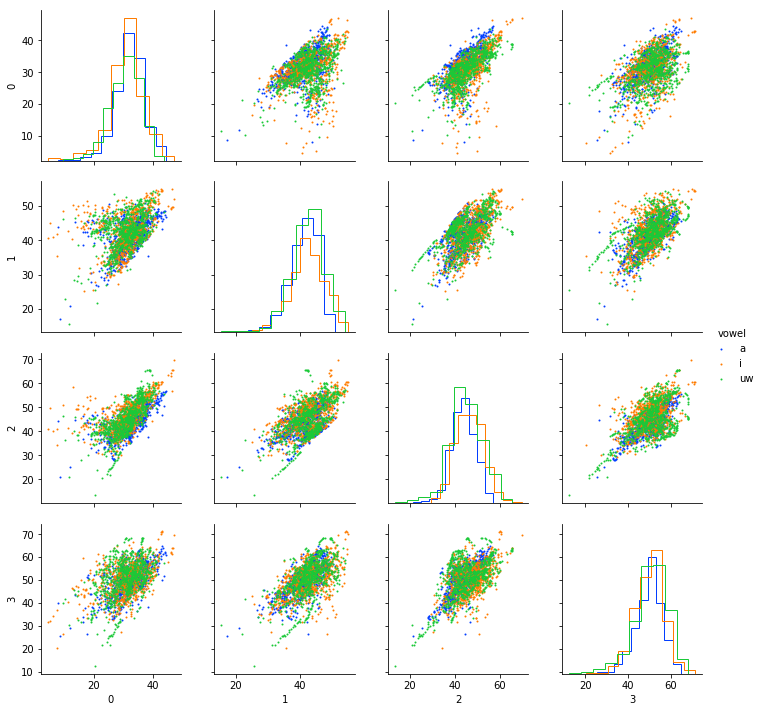

In [4]:
# we use the sns.PairGrid method to construct a multitue of scatter plots over the first 
# filterbank coefficients
dfX = pd.DataFrame(FB_train[:,0:4])
dfy = pd.Series(y_train, name='vowel')
df = pd.concat([dfy, dfX], axis=1)
f=plt.figure(figsize=(10,10))
g = sns.PairGrid(df,hue="vowel")
g.map_diag(plt.hist,histtype="step", linewidth=1)
g.map_offdiag(plt.scatter,s=1)
g.add_legend()

### 3b. Data Exploration .. of projected data

While there might be lots of information in this 24-dimensional data. It is not simple to observe it.
Definitely we do not find in the first couple of filterbank coefficients.
We definitely run into the limitations of 3-D visual representation.

A very common alternative for a quick analysis is to project the data on its most important axis.
PCA can be used for that blind of the labels that might exist.
We will not give any mathematical background here, but just think of looking in the best possible 2D subspace of the full 24-dimensional space.

##### Tasks & Questions (2)
1. What do these new scatter plots tell you?
2. In what units are the PCA-axis ?
3. Any idea if the original filterbank features will perform better or worse than the PCA features ?

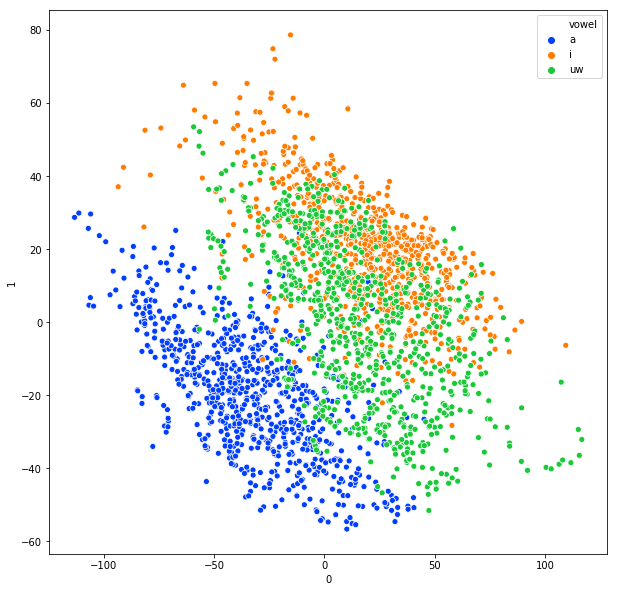

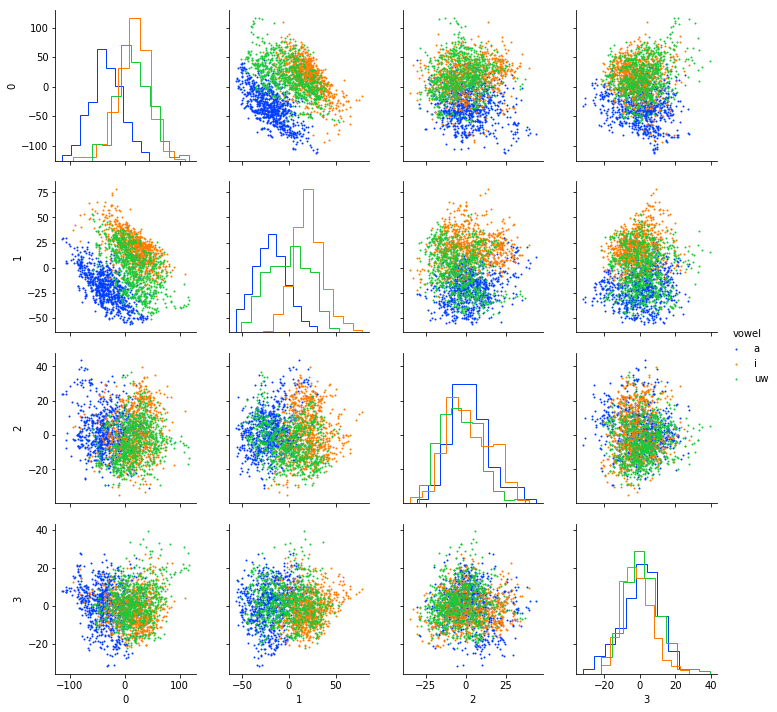

In [6]:
from sklearn.decomposition import PCA

pca = PCA()
T = pca.fit(FB_train)
PCA_train = T.transform(FB_train)
PCA_test = T.transform(FB_test)
dfX = pd.DataFrame(PCA_train[:,0:4])
dfy = pd.Series(y_train, name='vowel')
df = pd.concat([dfy, dfX], axis=1)
#
f=plt.figure(figsize=(10,10))
sns.scatterplot(data=df,x=0,y=1,hue='vowel')
g = sns.PairGrid(df,hue="vowel")
g.map_diag(plt.hist,histtype="step", linewidth=1)
g.map_offdiag(plt.scatter,s=1)
g.add_legend()

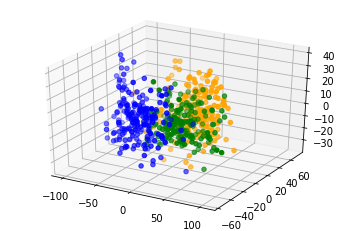

In [7]:
# we can also try to look in 3D ...
# .. but that's the limit of our visual capacity and the data is still 24-D !
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.loc[0:200,0], df.loc[0:200,1], df.loc[0:200,2], c='blue', s=20)
ax.scatter(df.loc[800:1000,0], df.loc[800:1000,1], df.loc[800:1000,2], c='orange', s=20)
ax.scatter(df.loc[1600:1800,0], df.loc[1600:1800,1], df.loc[1600:1800,2], c='green', s=20)
plt.show()


### 3c. Data Exploration .. MFCC features

While PCA is a very common technique in machine learning in general it is not commonly used in the speech recognition community.   Two alternatives give consistently better performance: LDA or CEPSTRAL transformations.
Both are linear transformations, similar to PCA, but conceptually quite different
- PCA looks at the data as a whole and tries to render a look along the most discriminative axis; it's main disadvantage is that it learns from the data but is blind to classification information
- LDA does the same, however it wants to maximize discrimination given class labels on top of the raw data; it does consistently outperform PCA but has as disadvantage that it is learned from the data, making it susceptible to anomalies in the training data
- The Cepstrum: is a fixed DCT transform.  Its performs is close to LDA (though somewhat inferior in general) and has as great advantage that it is fixed and not learned; making it generic across all languages, noise environments, ..   It has as general property that it yields compact (low-dimensional) highly decorrelated data making it often a very good starting point for speech recognition.

MFCC's: Mel Frequency Cepstra
=============================
MFCC's are obtained by taking a DCT (discrete cosine transform) of log filterbank energies.
The FBANK features we start from in this exercise are these log filterbank energies.
While the FBANK's here are 24-D, we typically limit the dimensionality of the cepstra to 13.  (we will do the selection at the moment of the recognition experiments)


##### Tasks & Questions (2)
1. What do these new scatter plots tell you?
2. In what units are the PCA-axis ?
3. Any idea if the original filterbank features will perform better or worse than the PCA features ?


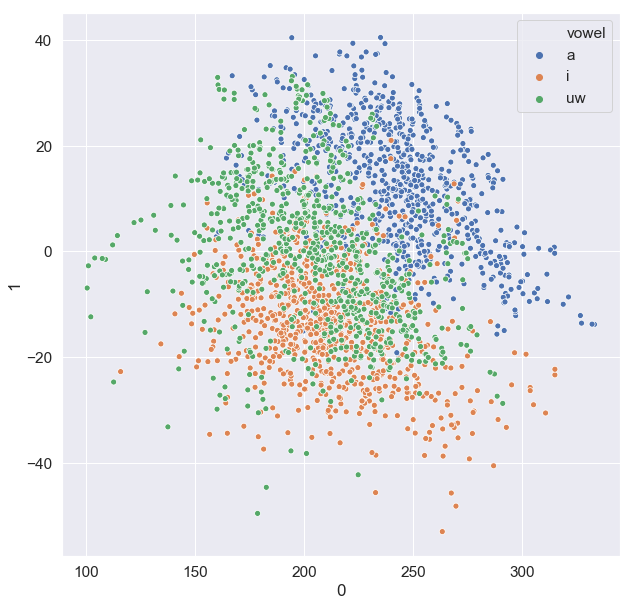

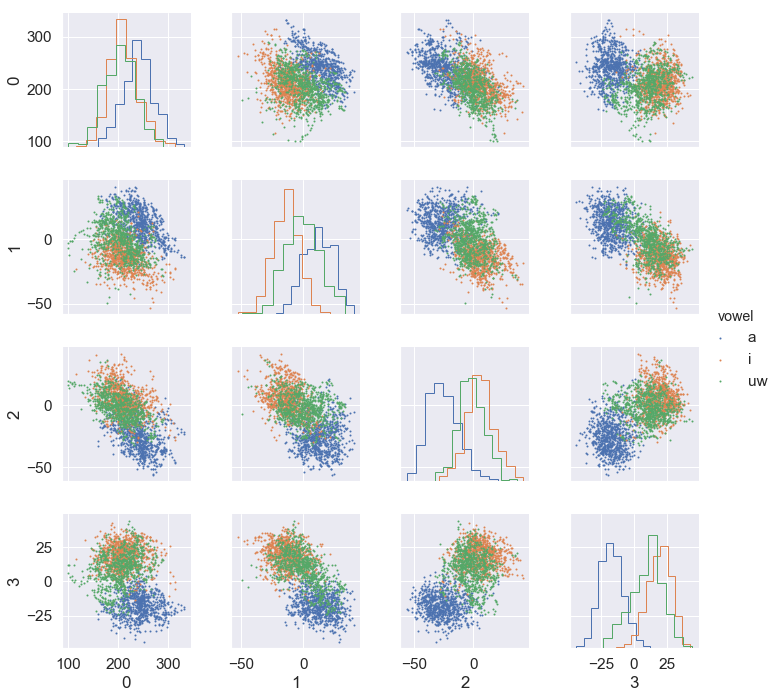

In [96]:
MFCC_train = dct(FB_train, type=2, axis=1, norm='ortho')
MFCC_test = dct(FB_test, type=2, axis=1, norm='ortho')
dfX = pd.DataFrame(MFCC_train[:,0:4])
dfy = pd.Series(y_train, name='vowel')
df = pd.concat([dfy, dfX], axis=1)
#
f=plt.figure(figsize=(10,10))
sns.scatterplot(data=df,x=0,y=1,hue='vowel')
g = sns.PairGrid(df,hue="vowel")
g.map_diag(plt.hist,histtype="step", linewidth=1)
g.map_offdiag(plt.scatter,s=1)
g.add_legend()

### 4. Classification using a Bayesian classifier and Gaussian models

We will use the class *GaussianMixtureClf* which as provided in *spchutils* .
It is implemented as an extension to *sklearn*, making use of the sklearn GaussianMixture density estimator, as we used before. 

There are a number of parameters that you may adjust in the following code blocks
- n_components:  the number of mixtures used in the Gaussian MM
- n_dim: the dimension of the feature vector (should be less than 24 in all cases)
- feature_type: "MFCC", "FBANK" or "PCA"
- max_iter:  maximum number of iterations in EM algorithm 

##### Note
You may get convergence warnings with certain settings.  It is probably an indication that you are trying to fit too many parameters with the available data.
In this case it probably is an indication that n_components is too big for the available data

##### Task & Questions (3)
1. How important in n_dim ?
2. How important is n_components ?
3. How important is it in this case to do PCA first ?
4. How similar is test performance on an independent test set when compared with predicted performance from train set ?  Do you see differences between the 3 different feature types?  Do you see differences with increasing feature dimension and number of components ?

In [112]:
from spchutils.GaussianMixtureClf import GaussianMixtureClf
# --------------
feature_type = "MFCC"  # any of MFCC, FBANK or PCA
n_dim_test = [1,3, 13 ]   # list of feature dimensions to test
n_components_test = [1,4]   # list of n_components to test
max_iter = 40      # maximum number of iterations in the EM algorithm

# --------------

for n_dim in n_dim_test:
    for n_components in n_components_test:
        if feature_type == "PCA":
            X_train = FB_pca_train[:,0:n_dim]   
            X_test  = FB_pca_test[:,0:n_dim]    
        elif feature_type == "FBANK":
            X_train = FB_train[:,0:n_dim]   
            X_test  = FB_test[:,0:n_dim]
        elif feature_type == "MFCC":
            X_train = MFCC_train[:,0:n_dim]   
            X_test  = MFCC_test[:,0:n_dim]    

        clf_GM = GaussianMixtureClf(classes=classes,n_components=n_components,max_iter=max_iter,tol=1.e-3)
        clf_GM.fit(X_train,y_train)
        # 2. print the model
        #clf_GM.print()
        #print("Classes: ",clGM.classes_)
        print("*** feature_type(dim=%d), n_components=%d ***" % (n_dim,n_components))
        y_pred = clf_GM.predict(X_train)
        print('Train Set Accuracy: %.2f%%' % (100.0*skmetrics.accuracy_score(y_train, y_pred)))
        y_pred = clf_GM.predict(X_test)
        print('Test Set Accuracy: %.2f%%' % (100.0*skmetrics.accuracy_score(y_test, y_pred)))

*** feature_type(dim=1), n_components=1 ***
Train Set Accuracy: 49.54%
Test Set Accuracy: 49.83%
*** feature_type(dim=1), n_components=4 ***
Train Set Accuracy: 51.54%
Test Set Accuracy: 52.50%
*** feature_type(dim=3), n_components=1 ***
Train Set Accuracy: 75.17%
Test Set Accuracy: 74.17%
*** feature_type(dim=3), n_components=4 ***
Train Set Accuracy: 76.50%
Test Set Accuracy: 71.00%
*** feature_type(dim=13), n_components=1 ***
Train Set Accuracy: 84.42%
Test Set Accuracy: 83.33%
*** feature_type(dim=13), n_components=4 ***
Train Set Accuracy: 86.50%
Test Set Accuracy: 80.33%


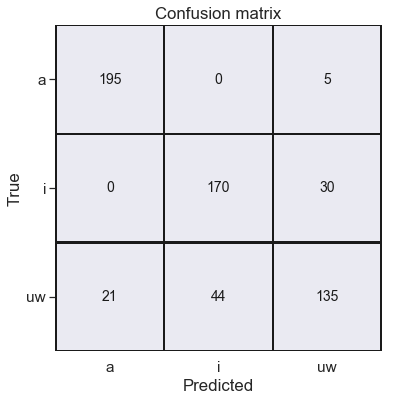

Accuracy: 83.33%


In [106]:
# A Confusion Matrix gives a more detailed image of the errors that we make
# The routine makes for pretty printing
def plot_confusion_matrix(cm,labels=[],cmap=[]):
    import seaborn as sns

    if len(labels) == 0:
        df_cm = pd.DataFrame(cm)
    else:
        df_cm = pd.DataFrame(cm, labels, labels)
        
    f,ax = plt.subplots(figsize=(6,6))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,fmt="d",annot_kws={"fontsize": 14,"color":'k'},
                square=True,linecolor='k',linewidth=1.5,cmap=cmap,cbar=False)
    ax.tick_params(axis='y',labelrotation=0.0,left=True)
    # font size
    plt.title('Confusion matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

y_pred = clf_GM.predict(X_test)
cmat = skmetrics.confusion_matrix(y_test,y_pred)
#print('Confusion Matrix:\n',cmat)    
    
plot_confusion_matrix(cmat,labels=classes)
print('Accuracy: %.2f%%' % (100.0*skmetrics.accuracy_score(y_test, y_pred)))